In [1]:
import numpy as np
import fdasrsf as fs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")


In [2]:
np.random.seed(0)

y =pd.read_csv("../datasets/Mouse/y_600.csv",index_col=0)
X = np.load("../datasets/Mouse/X_600.npy")
X_mask = np.load("../datasets/Mouse/X_600_mask.npy")
X = X[:,::2,:]
X = X[:,:,1].squeeze()
X_mask = X_mask[:,::2,:]
SAMPFREQ = 1000

lst = []
for filename in y[y.genotype.isin(["colq","wt"])].filename.unique(): 
    idx = y[(y.before == "Y")*(y.filename == filename)].sample(25).index
    lst.append(idx)
    idx = y[(y.before == "N")*(y.filename == filename)].sample(50).index
    lst.append(idx)

idxs = np.concatenate(lst)
X,X_mask = X[idxs],X_mask[idxs]
y = y.iloc[idxs]

Text(0.5, 1.0, 'Durations -- avg 342 -- median: 307')

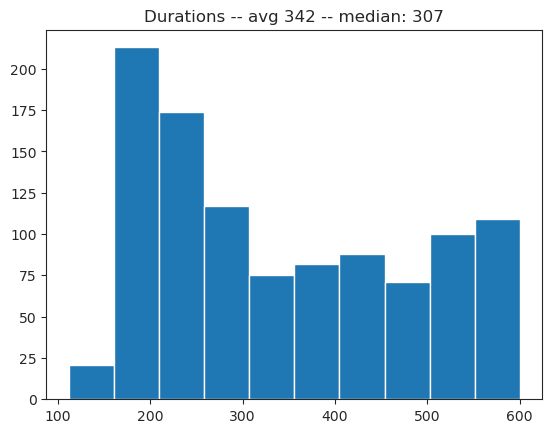

In [3]:
lengths = np.sum(X_mask,axis=1).squeeze()
plt.hist(lengths)
plt.title(f"Durations -- avg {np.mean(lengths).astype(int)} -- median: {np.median(lengths).astype(int)}")

In [4]:
N_SAMPLES = 200

# I. RESAMPLING

In [5]:
from scipy.interpolate import interp1d

In [6]:
lst = []
time = np.linspace(0,1,N_SAMPLES)
for ts,mask in zip(X,X_mask.squeeze()):
    s = ts[mask]
    x = np.linspace(0,1,s.shape[0]) 
    f = interp1d(x,s,kind="linear")
    lst.append(f(time))
arr = np.array(lst)

# II. Shape Functionnal PCA

In [7]:
obj = fs.fdawarp(arr.T,time)
obj.srsf_align(parallel=True,cores=20)


Initializing...
Compute Karcher Mean of 1050 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


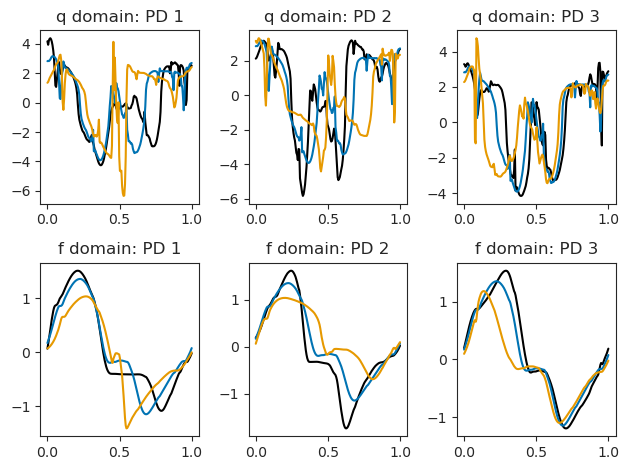

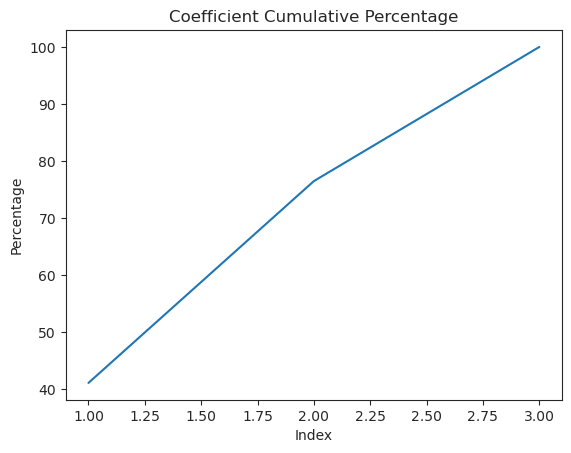

In [8]:
N_COMP = 3 
jpca = fs.fdajpca(obj)
jpca.calc_fpca(no=N_COMP,stds = np.array([-1.5,0,1.5]),parallel=True,cores =20)
jpca.plot()

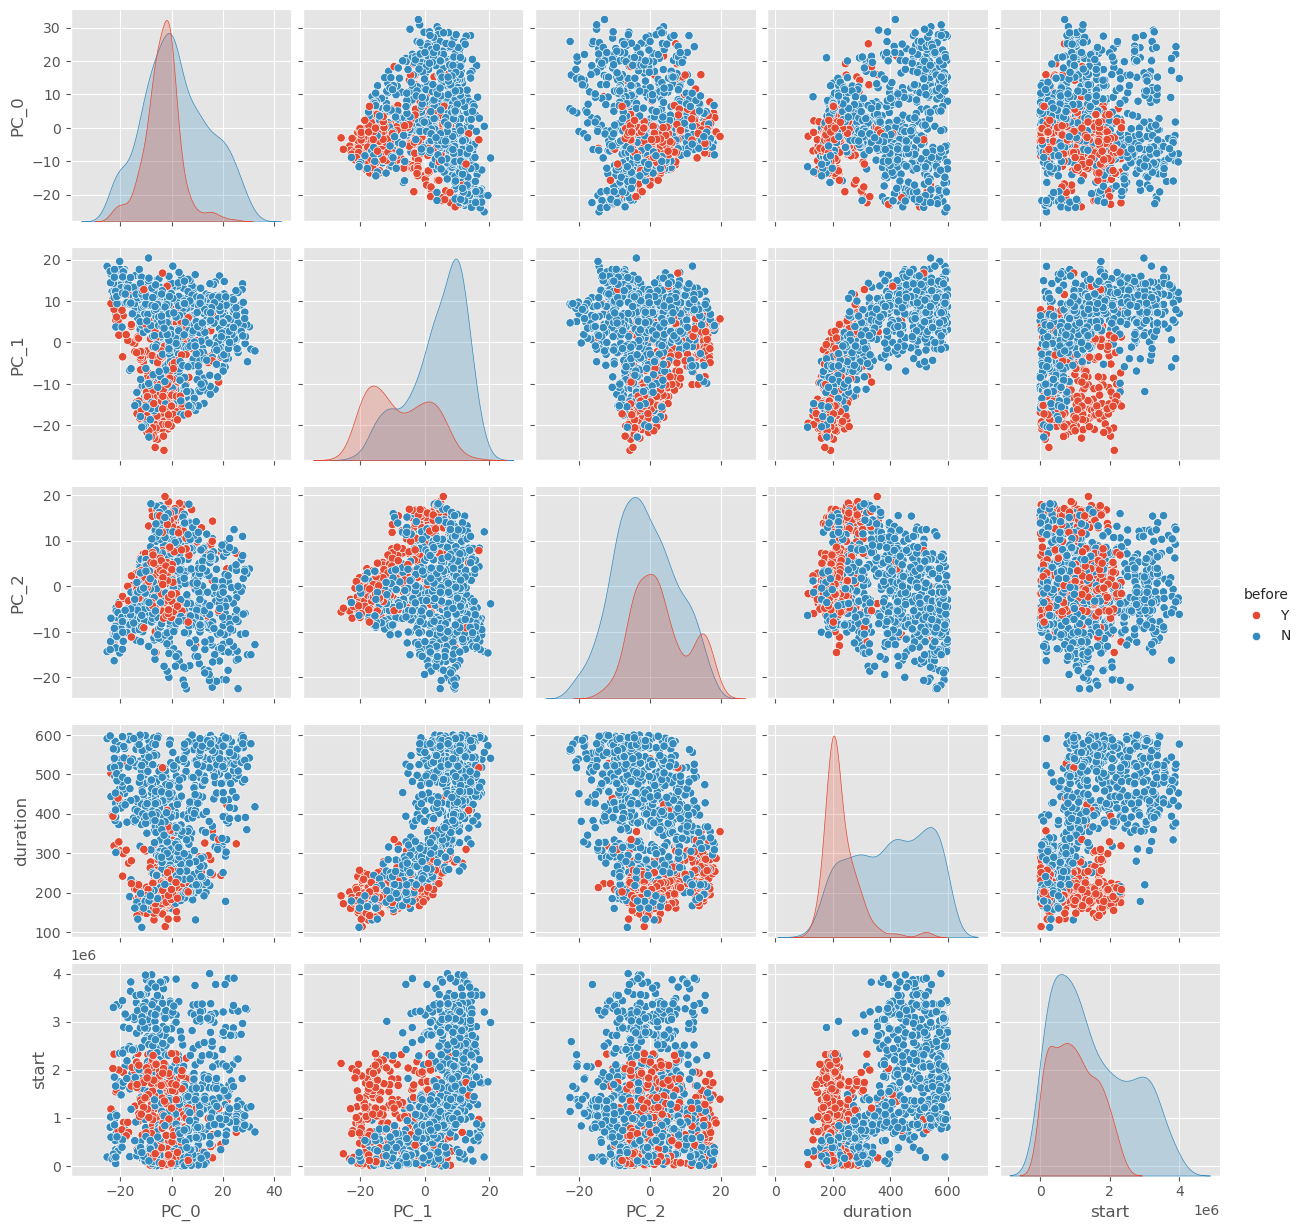

In [11]:
df = pd.DataFrame(jpca.coef,columns = [f"PC_{i}" for i in range(N_COMP)])
df["duration"] = lengths
df["genotype"] = y.genotype.values
df["before"] = y.before.values
df["start"] = y.start.values
sns.pairplot(df,hue="before")

# REVIEWER OPTION

In [12]:
import fdasrsf.utility_functions as uf

In [14]:
gobj = fs.fdawarp(obj.gam * lengths[None,:],time)
gobj.srsf_align()

Initializing...
Compute Karcher Mean of 1050 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3


updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9


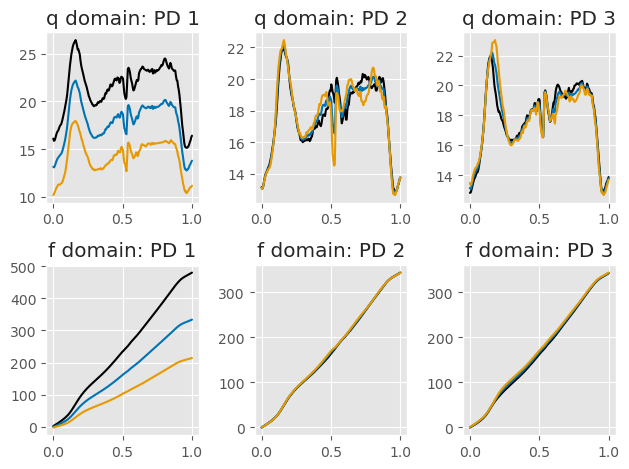

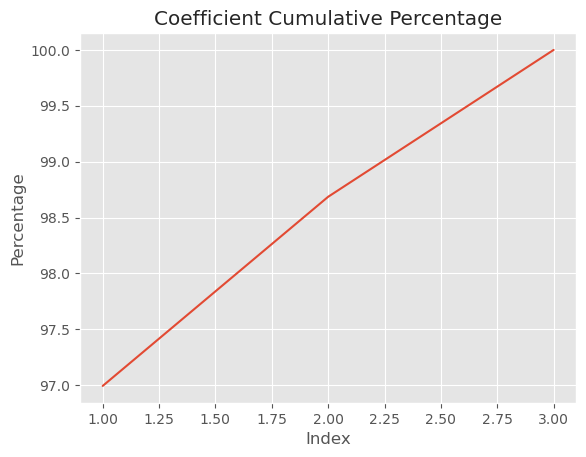

In [15]:
gvpca = fs.fdavpca(gobj)
gvpca.calc_fpca()
gvpca.plot()

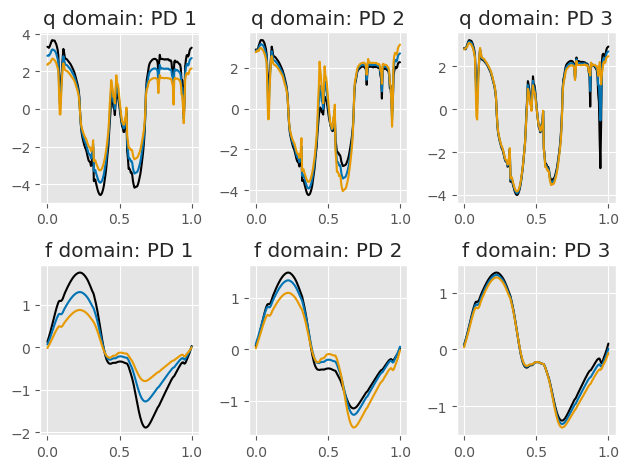

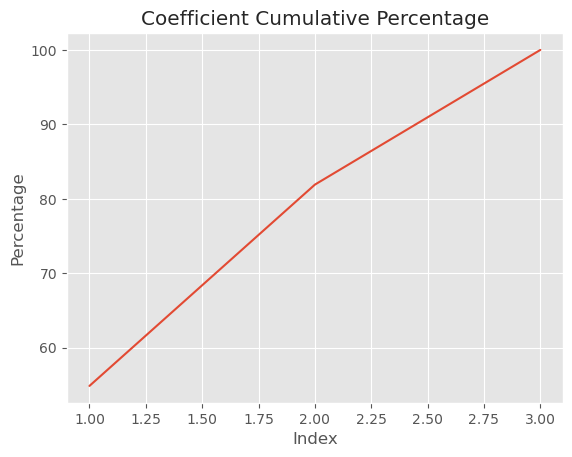

In [16]:
fvpca = fs.fdavpca(obj)
fvpca.calc_fpca()
fvpca.plot()

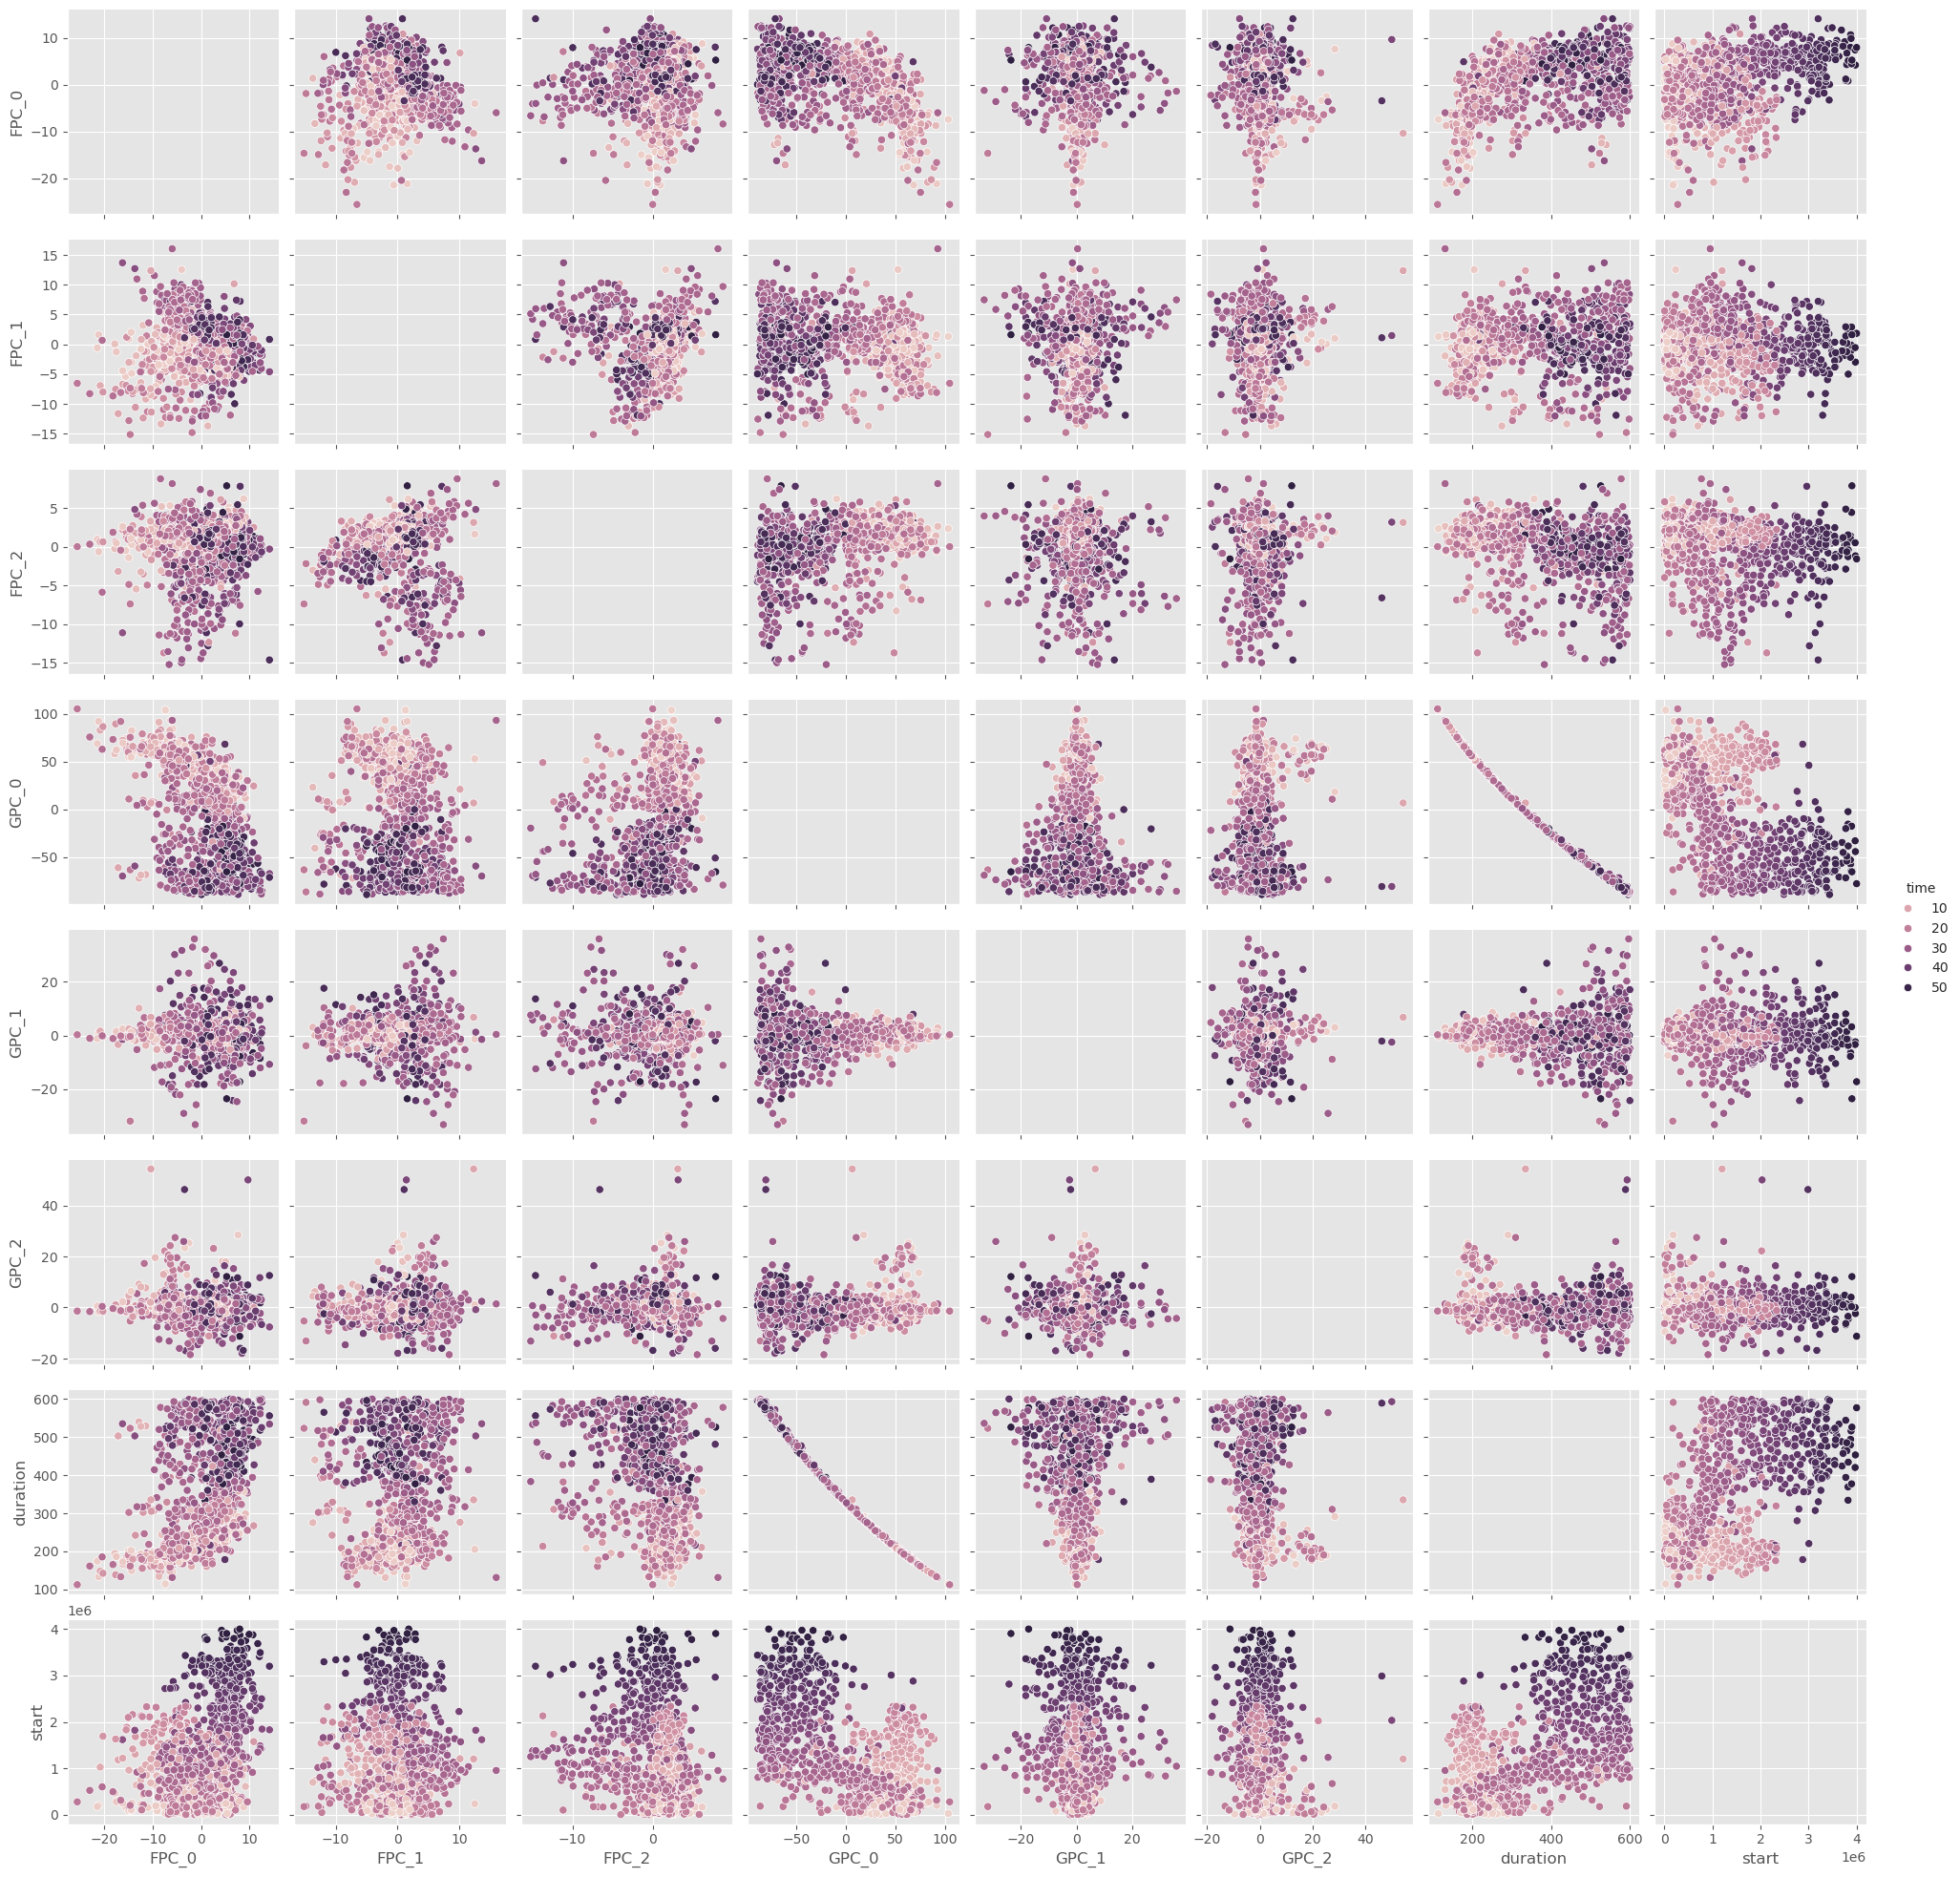

In [17]:
df1 = pd.DataFrame(fvpca.coef,columns = [f"FPC_{i}" for i in range(N_COMP)])
df2 = pd.DataFrame(gvpca.coef,columns = [f"GPC_{i}" for i in range(N_COMP)])
df = pd.concat((df1,df2),axis=1)
df["duration"] = lengths
df["genotype"] = y.genotype.values
df["before"] = y.before.values
df["start"] = y.start.values
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
sns.pairplot(df,hue="time")

# COMBINED

In [18]:
from sklearn.decomposition import PCA

In [19]:
def preprocessing(obj):
    mididx = obj.qn.shape[0]//2
    qn = obj.qn
    fn = obj.qn
    mq_new = qn.mean(axis=1)
    m_new = np.sign(fn[mididx, :]) * np.sqrt(np.abs(fn[mididx, :]))
    mqn = np.append(mq_new, m_new.mean())
    qn2 = np.vstack((qn, m_new))
    return mqn, qn2

In [22]:
C = 1
mqf,qf = preprocessing(obj)
mqg,qg = preprocessing(gobj)
qs = np.vstack((qf,C*qg)).T
pca = PCA(3)
pca.fit(qs)
val = pca.transform(qs)


In [23]:
def compute_function(vec):
    M = (vec.shape[0]-1)
    time = np.linspace(0,1,M)
    f = uf.cumtrapzmid(time, vec[0:M]*np.fabs(vec[0:M]), np.sign(vec[M])*(vec[M]*vec[M]), M//2)
    return f

def shoot(fvec,gvec): 
    f = compute_function(fvec)
    g = compute_function(gvec)
    duration = g.max() - g.min()
    g = g - g.min()
    return f,g

In [24]:
sigmas = [-1.5,0,1.5]
fs = np.zeros((N_COMP,len(sigmas),N_SAMPLES))
gs = np.zeros((N_COMP,len(sigmas),N_SAMPLES))

for i in range(N_COMP): 
    vf,vg = pca.components_[i,:N_SAMPLES+1],pca.components_[i,N_SAMPLES+1:]
    s = np.sqrt(pca.explained_variance_[i])
    for j,sigma in enumerate(sigmas): 
        sf = mqf + s *sigma * vf
        sg = mqg + s * sigma * vg
        fs[i,j],gs[i,j] = shoot(sf,sg)

        


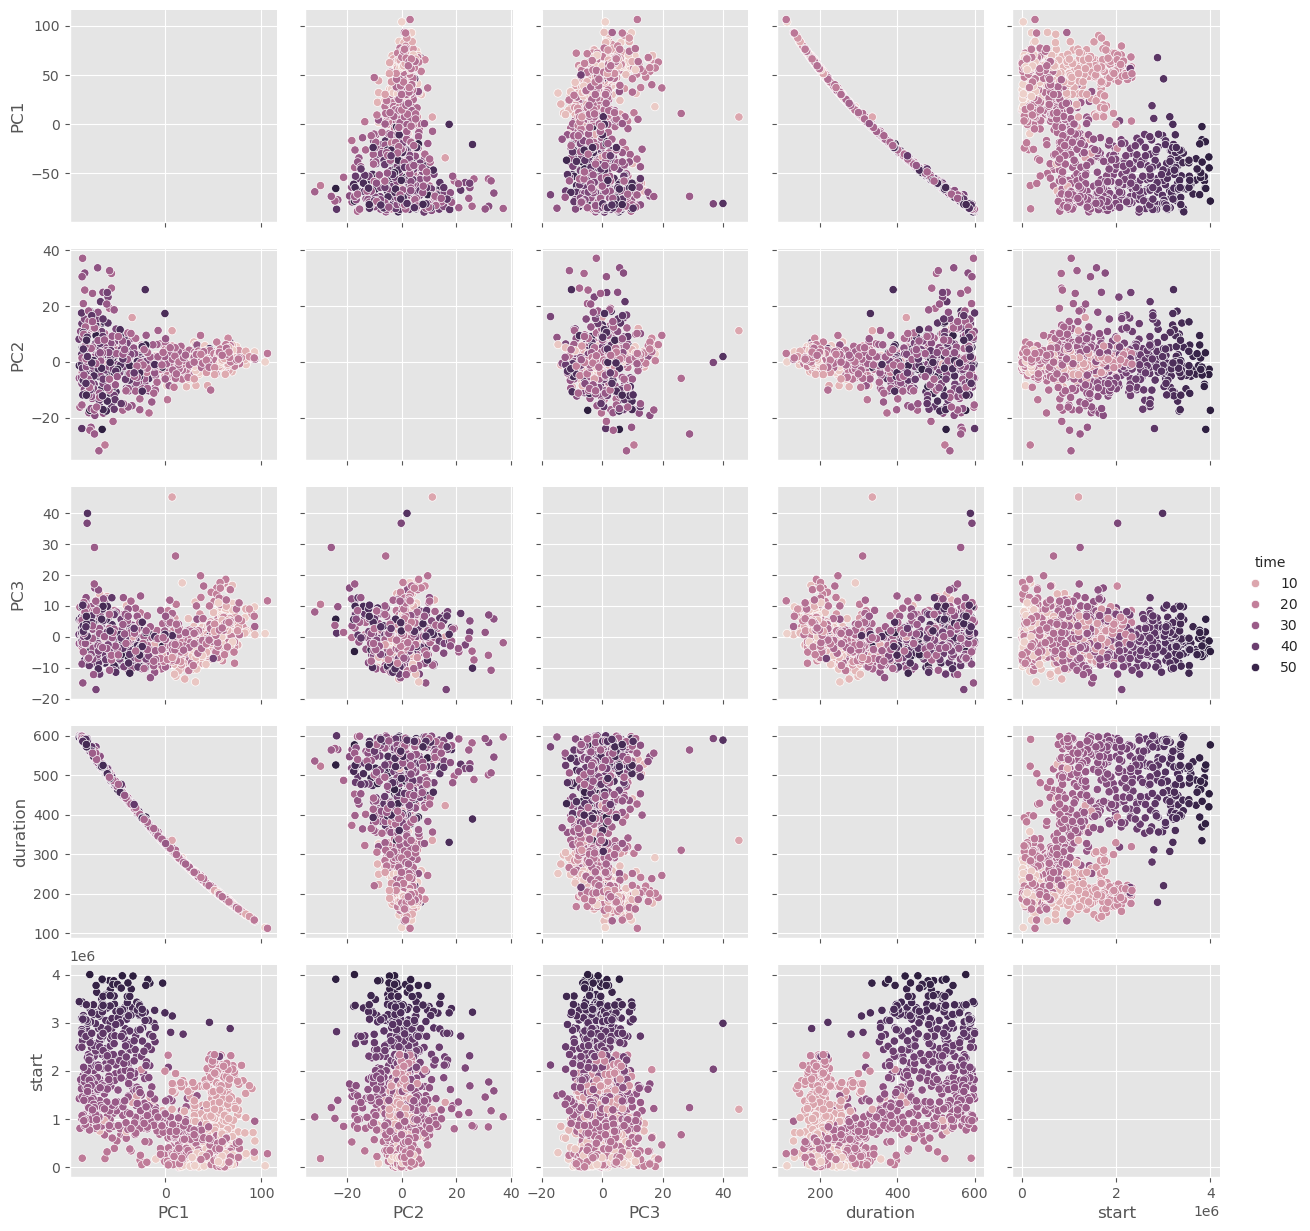

In [26]:
df = pd.DataFrame(val,columns = [f"PC{i+1}" for i in range(N_COMP)])
df["duration"] = lengths
df["genotype"] = y.genotype.values
df["before"] = y.before.values
df["before"] = y.before.values
df["start"] = y.start.values
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
sns.pairplot(df,hue="time")

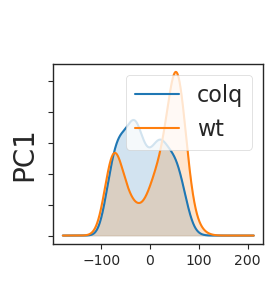

In [36]:
from scipy.stats import gaussian_kde
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(N_COMP)]
span =1.0
nsample = 10000
ft_size = 20
pft_size = 16



fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (3,3))
r = df["PC1"].values.max()
l = df["PC1"].values.min()
x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
for gen,color in color_mapping.items(): 
    arr = df[df.genotype == gen]["PC1"].values
    z = gaussian_kde(arr)(x)
    ax.plot(x,z,color=color,label=gen)
    ax.fill_between(x,z,color=color,alpha=0.2)
    ax.set_ylabel("PC1",fontsize=ft_size)

ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.legend(fontsize=pft_size)
#ax.set_title("A) PC density",fontsize=ft_size)
ax.set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/jpca_densities.svg")

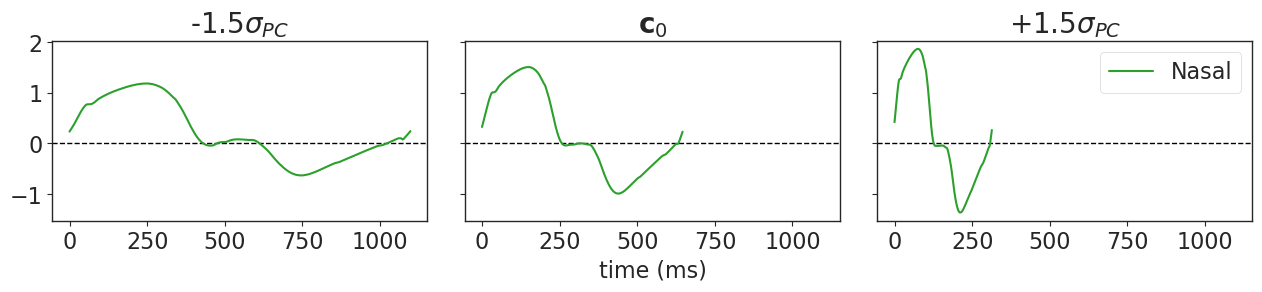

In [37]:
ncomp,ndisp = 1,3

sns.set_style("ticks")

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*5,3),sharex=True,sharey=True)
for j,(g,f)in enumerate(zip(gs[0],fs[0])):
    axs[j].plot(g*2,f,color="tab:green",label="Nasal")

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0].set_title(r"-1.5$\sigma_{PC}$",fontsize=ft_size)
axs[1].set_title(r"$\mathbf{c}_0$",fontsize=ft_size)
axs[2].set_title(r"+1.5$\sigma_{PC}$",fontsize=ft_size)
axs[2].legend(fontsize = pft_size)
for ax in axs:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs:
    ax.yaxis.set_tick_params(labelsize=pft_size)

#fig.suptitle("B) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/jpca_shooting.svg")


/tmp/ipykernel_1314513/3339313005.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('plasma')
/tmp/ipykernel_1314513/3339313005.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)


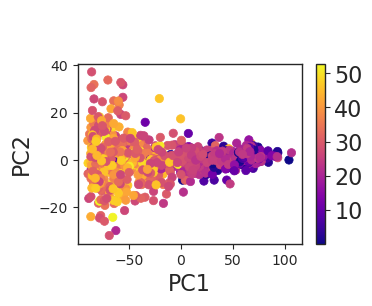

In [38]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (4,3))
x = df.PC1.values
z = df.PC2.values
c = df.time.values
cm = plt.cm.get_cmap('plasma')
sc = ax.scatter(x,z,c=c,cmap = cm)
cbar = fig.colorbar(sc)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=pft_size)
    

#ax.set_yticklabels([])
#ax.set_xticklabels([])
#ax.set_title("C) PC1/PC2 time",fontsize=ft_size)
ax.set_ylabel("PC2",fontsize=pft_size)
ax.set_xlabel("PC1",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.8,wspace=0.1,hspace=0.1)
fig.savefig("./figures/jpca_scatter.svg")